In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pointbiserialr, spearmanr, chi2_contingency, shapiro, norm
from statsmodels.stats.proportion import proportion_confint

file_path_externals = ['whisper_large_v2_32_rwe_test_v5_160_all.csv',
             'hubert_chinese_19_rwe_v5_160_new.csv',
             'wavlm_12_rwe_v5_160_new.csv']
file_path_internals = ['whisper_large_v2_32_v41_test_all.csv',
             'hubert_chinese_19_v41_test_usd.csv',
             'wavlm_12_v41_test_usd.csv']

In [2]:
model_name_externals = ['whisper', 'hubert', 'wavlm'] 
model_name_internals = ['whisper', 'hubert', 'wavlm']

In [3]:
def bootstrap_auc(true_labels, predictive_values, n_bootstraps=2000, alpha=0.05):
    bootstrapped_scores = []
    rng = np.random.RandomState(seed=42)  # Control reproducibility

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(true_labels), len(true_labels))
        if len(np.unique(true_labels[indices])) < 2:
    
            continue
        
        score = roc_auc_score(true_labels[indices], predictive_values[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    lower = np.percentile(sorted_scores, 100*alpha/2)
    upper = np.percentile(sorted_scores, 100*(1-alpha/2))
    return lower, upper

In [4]:
def calculate_sensitivity_specificity(true_labels, predictive_values):
    tn, fp, fn, tp = confusion_matrix(true_labels, predictive_values).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

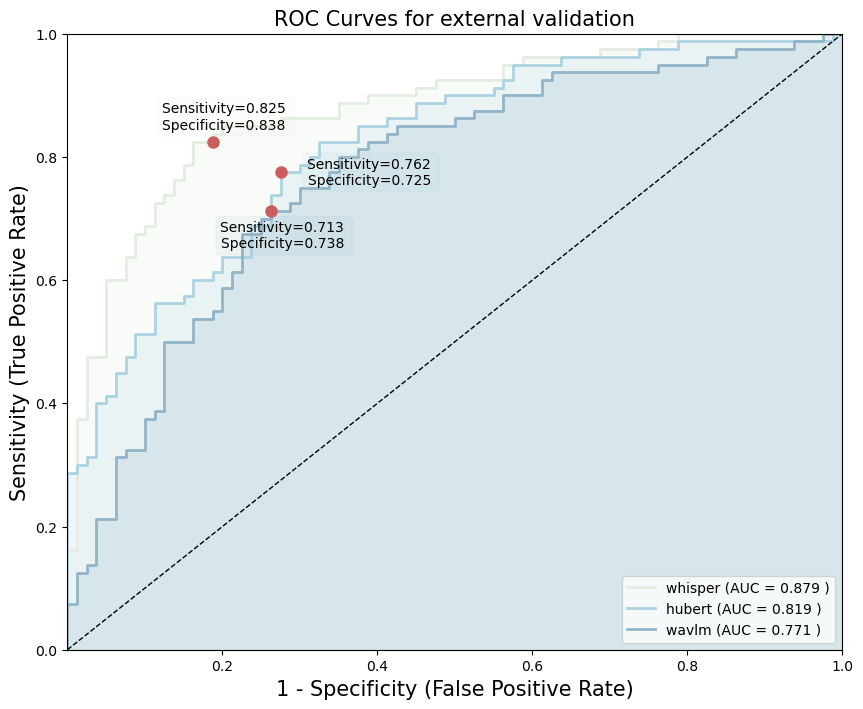

In [7]:
colors = ['#E3EDE0', '#ABD3E1', '#92B4C8'] 
figure_size = (10, 8)
plt.figure(figsize=figure_size)
for i, file_path_external in enumerate(file_path_externals):
    data = pd.read_csv(file_path_external)
    predictive_values = data['depressed_score']
    true_labels = data['target_label']
    
    y_pred = (predictive_values >= 0.5).astype(int)
    sensitivity, specificity = calculate_sensitivity_specificity(true_labels, y_pred)
    fpr, tpr, thresholds = roc_curve(true_labels, predictive_values)
    roc_auc = auc(fpr, tpr)
    idx = np.argmin(np.abs(thresholds - 0.5))
    cut_off_fpr = fpr[idx]
    cut_off_tpr = tpr[idx]
    
    sens_lower, sens_upper = proportion_confint(count=sensitivity * np.sum(true_labels), nobs=np.sum(true_labels), alpha=0.05, method='wilson')
    spec_lower, spec_upper = proportion_confint(count=specificity * (len(true_labels) - np.sum(true_labels)), nobs=(len(true_labels) - np.sum(true_labels)), alpha=0.05, method='wilson')
    auc_lower, auc_upper = bootstrap_auc(true_labels, predictive_values)

    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_name_externals[i]} (AUC = {roc_auc:.3f} )')    
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color=colors[i])
    x_offsets = [0.1, 0.2, 0.1]
    text_x = fpr[idx] + x_offsets[i]
    y_offsets = [0.04, 0, -0.04]
    text_y = tpr[idx] + y_offsets[i]
    plt.plot(cut_off_fpr, cut_off_tpr, marker='o', color='indianred', markersize=8)
    plt.annotate(f'Sensitivity={sensitivity:.3f} \nSpecificity={specificity:.3f} ', 
                 xy=(fpr[idx], tpr[idx]), xytext=(text_x, text_y),
                 textcoords="data", ha='right', va='center',
                 bbox=dict(boxstyle="round", alpha=0.1, color=colors[i]))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize = 15)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 15)
plt.title('ROC Curves for external validation', fontsize = 15)
plt.legend(loc="lower right")

plt.gca().set_xticks(plt.gca().get_xticks()[1:])
plt.show()

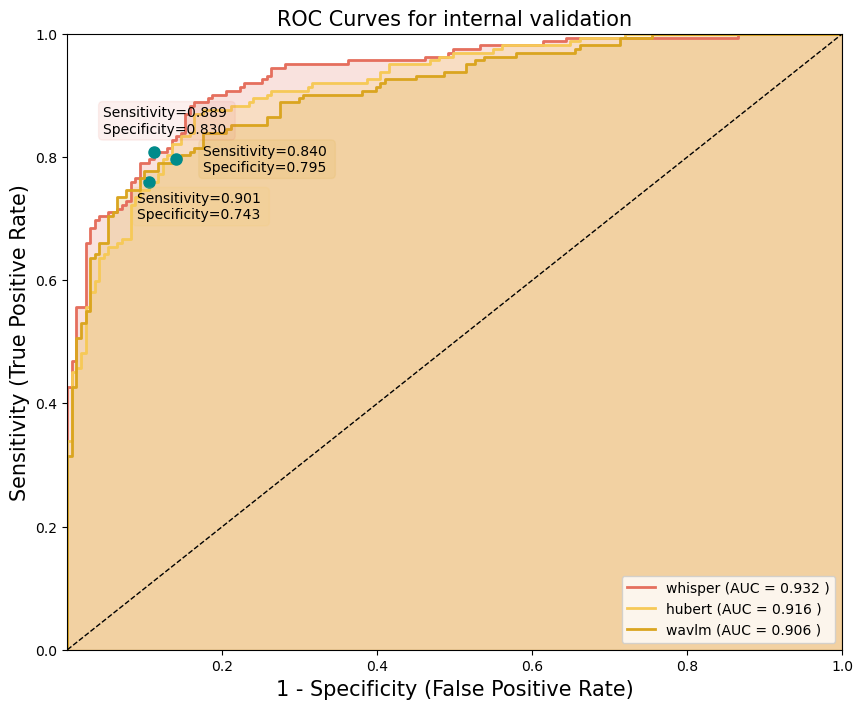

In [10]:
colors = ['#E56F5E', '#F6C957', 'goldenrod'] 
figure_size = (10, 8)
plt.figure(figsize=figure_size)
for i, file_path_internal in enumerate(file_path_internals):
    data = pd.read_csv(file_path_internal)
    predictive_values = data['depressed_score']
    true_labels = data['target_label']
    
    y_pred = (predictive_values >= 0.5).astype(int)
    sensitivity, specificity = calculate_sensitivity_specificity(true_labels, y_pred)
    fpr, tpr, thresholds = roc_curve(true_labels, predictive_values)
    roc_auc = auc(fpr, tpr)
    sens_lower, sens_upper = proportion_confint(count=sensitivity * np.sum(true_labels), nobs=np.sum(true_labels), alpha=0.05, method='wilson')
    spec_lower, spec_upper = proportion_confint(count=specificity * (len(true_labels) - np.sum(true_labels)), nobs=(len(true_labels) - np.sum(true_labels)), alpha=0.05, method='wilson')
    auc_lower, auc_upper = bootstrap_auc(true_labels, predictive_values)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_name_internals[i]} (AUC = {roc_auc:.3f} )')    
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color=colors[i])
    x_offsets = [0.1, 0.15, 0.2]
    text_x = fpr[idx] + x_offsets[i]
    y_offsets = [0.05, -0.04, 0]
    text_y = tpr[idx] + y_offsets[i]
    plt.plot(fpr[idx], tpr[idx], marker='o', color='darkcyan', markersize=8)
    plt.annotate(f'Sensitivity={sensitivity:.3f} \nSpecificity={specificity:.3f} ', 
                 xy=(fpr[idx], tpr[idx]), xytext=(text_x, text_y),
                 textcoords="data", ha='right', va='center',
                 bbox=dict(boxstyle="round", alpha=0.1, color=colors[i]))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize = 15)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 15)
plt.title('ROC Curves for internal validation', fontsize = 15)
plt.legend(loc="lower right")

plt.gca().set_xticks(plt.gca().get_xticks()[1:])
plt.show()